# Wave Collapse Function

In [1]:
from __future__ import annotations

import math
import random
from typing import Generator, Iterable, Optional

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib.artist import Artist
from tqdm.notebook import tqdm


## Utilities

Let define some grid object and way to navigate in the grid


In [2]:
DIR4 = [(0, -1), (1, 0), (0, 1), (-1, 0)]
DIR4C = [(0, 0), (0, -1), (1, 0), (0, 1), (-1, 0)]
DIR8 = [(-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0)]
DIR8C = [(0, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0)]

GridLoc = tuple[int, int]


class GridGenerator:
    def __init__(self, size: int, grad: list[GridLoc]):
        self.size = size
        self.grad = grad
        self.stencil = (0, 0, size, size)

    def set_stencil(self, stencil: tuple[int, int, int, int]):
        self.stencil = stencil

    def linear(self, visited: Optional[set[GridLoc]] = None) -> Generator[GridLoc, None, None]:
        v = visited or set()
        for y in range(self.stencil[1], self.stencil[3]):
            for x in range(self.stencil[0], self.stencil[2]):
                xy = (x, y)
                if xy not in v:
                    yield xy

    def neighbours(
        self,
        loc: GridLoc,
        visited: Optional[set[GridLoc]] = None,
        mode: str = "enclosed",
    ) -> Generator[GridLoc, None, None]:
        def is_inside(x, y):
            return self.stencil[0] <= x < self.stencil[2] and self.stencil[1] <= y < self.stencil[3]

        def wrap(x, y):
            return (x % self.size, y % self.size)

        x, y = loc
        v = visited or set()

        match mode:
            case "enclosed":
                for dx, dy in self.grad:
                    xy = (x + dx, y + dy)
                    if xy not in v and is_inside(*xy):
                        yield xy

            case "wrapped":
                for dx, dy in self.grad:
                    xy = wrap(x + dx, y + dy)
                    if xy not in v:
                        yield xy

    def propagate(self, loc: GridLoc, visited: Optional[set[GridLoc]] = None) -> Generator[GridLoc, None, None]:
        def step_once(loc, q, v):
            tmp = list(self.neighbours(loc, v))
            return q + tmp, v | set(tmp)

        q, v = step_once(loc, [], visited or set())
        while len(q) > 0:
            xy = q.pop(0)
            yield xy
            q, v = step_once(xy, q, v)


class Grid:
    @staticmethod
    def from_list(
        amap: list[list[dict]],
        grad: Optional[list[GridLoc]] = None,
        default: Optional[dict] = None,
    ) -> Grid:
        return Grid(amap, grad, default)

    @staticmethod
    def from_dict(
        size: int,
        adict: dict,
        grad: Optional[list[GridLoc]] = None,
        default: Optional[dict] = None,
    ) -> Grid:
        amap = [[adict.copy() for _ in range(size)] for _ in range(size)]
        return Grid(amap, grad, default)  # type: ignore

    @staticmethod
    def make_partitions(size: int, chunk: int) -> list[tuple[int, int, int, int]]:

        def partition(x, y, w, n):
            if n == 1:
                return [(x, y, x + w, y + w)]
            else:
                w_h, n_h = w // 2, n // 2
                return (
                    partition(x, y, w_h, n_h)
                    + partition(x + w_h, y, w_h, n_h)
                    + partition(x + w_h, y + w_h, w_h, n_h)
                    + partition(x, y + w_h, w_h, n_h)
                )

        return partition(0, 0, size, chunk)

    def __init__(
        self,
        amap: list[list[dict]],
        grad: Optional[list[GridLoc]] = None,
        default: Optional[dict] = None,
    ):
        assert len(amap) == len(amap[0]), "Grid must be square"
        self.size = len(amap)
        self.map = amap
        self.generator = GridGenerator(self.size, grad or DIR4C)
        self.default = default

    def clear(self, adict: dict):
        for x, y in self.generator.linear():
            self.map[y][x] = adict.copy()

    def set_stencil(self, stencil: tuple[int, int, int, int]):
        self.generator.set_stencil(stencil)

    def get_item(self, loc: Optional[GridLoc]) -> Optional[dict]:
        if loc is None:
            return self.default
        else:
            x, y = loc
            return self.map[y][x]

    def set_item(self, loc: Optional[GridLoc], val: dict):
        if loc is not None:
            x, y = loc
            self.map[y][x] = val

    def random(self, visited: Optional[set[GridLoc]] = None) -> Generator[tuple[GridLoc, Optional[dict]], None, None]:
        queue = list(self.linear(visited))
        random.shuffle(queue)
        for e in queue:
            yield e

    def linear(self, visited: Optional[set[GridLoc]] = None) -> Generator[tuple[GridLoc, Optional[dict]], None, None]:
        for xy in self.generator.linear(visited):
            yield xy, self.get_item(xy)

    def neighbours(
        self,
        loc: GridLoc,
        visited: Optional[set[GridLoc]] = None,
        mode: str = "enclosed",
    ) -> Generator[tuple[GridLoc, Optional[dict]], None, None]:
        for xy in self.generator.neighbours(loc, visited, mode):
            yield xy, self.get_item(xy)

    def propagate(
        self, loc: GridLoc, visited: Optional[set[GridLoc]] = None
    ) -> Generator[tuple[GridLoc, Optional[dict]], None, None]:
        for xy in self.generator.propagate(loc, visited):
            yield xy, self.get_item(xy)

    def __len__(self):
        return self.size

    def __getitem__(self, loc):
        return self.get_item(loc)

    def __setitem__(self, loc, val):
        self.set_item(loc, val)


Let test it


[(0, 0, 10, 10), (10, 0, 20, 10), (10, 10, 20, 20), (0, 10, 10, 20)]

[(1, 0), (2, 1), (1, 2), (0, 1)]

[(1, 1), (1, 0), (2, 1), (1, 2), (0, 1)]

[(1, 0), (2, 1), (1, 2), (0, 1), (2, 0), (0, 0), (2, 2), (0, 2)]

[(1, 1), (1, 0), (2, 1), (1, 2), (0, 1), (2, 0), (0, 0), (2, 2), (0, 2)]

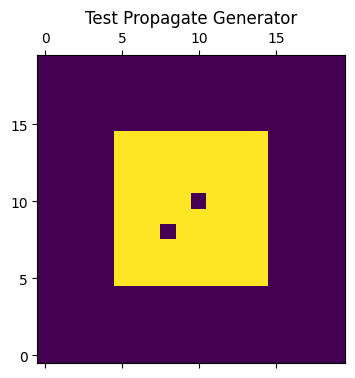

In [3]:
N = 20
ON = 255

display(Grid.make_partitions(20, 2))

display(list(GridGenerator(3, DIR4).neighbours((1, 1), {(1, 1)})))
display(list(GridGenerator(3, DIR4C).neighbours((1, 1))))
display(list(GridGenerator(3, DIR4).propagate((1, 1), {(1, 1)})))
display(list(GridGenerator(3, DIR4C).propagate((1, 1))))

grid = Grid.from_list(list(np.zeros(N * N).reshape(N, N)), DIR4C)
grid.generator.set_stencil((5, 5, 15, 15))

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title("Test Propagate Generator")
ax.set_xlim((-0.5, N - 0.5))
ax.set_ylim((-0.5, N - 0.5))


def update_frame(frame: tuple[GridLoc, object]) -> Iterable[Artist]:
    loc, _ = frame
    grid[loc] = ON
    return ax.matshow(grid.map) # type: ignore


ani = animation.FuncAnimation(
    fig,
    update_frame,
    frames=grid.propagate((N // 2, N // 2), {(8, 8), (10, 10)}),
    interval=30,
    save_count=N**2,
)
HTML(ani.to_jshtml())

## The algorithm


In [4]:
def shannon_entropy(vec: dict[str, tuple[float, int]]) -> float:
    match len(vec):
        case 0:
            return float("inf")
        case 1:
            return 0
        case _:
            values = [p_x * math.log(p_x) for p_x, _ in vec.values() if p_x > 0]
            return -sum(values) if len(values) > 0 else float("inf")


def softmax(vec: dict[str, tuple[float, int]]) -> dict[str, tuple[float, int]]:
    sum_p_x = sum([math.exp(p_x) for p_x, _ in vec.values() if p_x > 0])
    return {x: (math.exp(attrs[0]) / sum_p_x, attrs[1]) for x, attrs in vec.items() if attrs[0] > 0}


def unpack_policies(packed_policies: dict[str, list[list[str]]]) -> dict[str, list[list[str]]]:
    def unpack(rem, acc, res):
        if len(rem) == 0:
            res.append(acc)
        else:
            head, *tail = rem
            for e in head:
                unpack(tail, acc + [e], res)
        return res

    return {name: unpack(policy, [], []) for name, policy in packed_policies.items()}


def collapse(tiles: dict[str, tuple[float, int]]) -> dict[str, tuple[float, int]]:
    values, attrs = zip(*tiles.items(), strict=False)
    weights, _ = zip(*attrs, strict=False)
    pick = random.choices(values, weights=weights)[0]
    return {t: (1, a[1]) for t, a in tiles.items() if t == pick}


def update(
    grid: Grid,
    loc: GridLoc,
    tiles: dict[str, tuple[float, int]],
    policies: dict[str, list[list[str]]],
) -> dict[str, tuple[float, int]]:
    neighbours = list(grid.neighbours(loc, visited={loc}, mode="wrapped"))

    def match(policy):
        return all(t.get(e) for (_, t), e in zip(neighbours, policy, strict=False))  # type: ignore

    return softmax({t: a for t, a in tiles.items() if any(match(policy) for policy in policies[t])})


def wave_collapse_function(
    tiles: dict[str, tuple[float, int]],
    policies: dict[str, list[list[str]]],
    size: int,
    chunk: int,
    grad: Optional[list[GridLoc]] = None,
    num_epochs: int = 100,
) -> Optional[Grid]:
    grid = Grid.from_dict(size, tiles, grad)
    partitions = Grid.make_partitions(size, chunk)

    for partition in tqdm(partitions, desc="Epoch"):
        grid.set_stencil(partition)

        for _ in range(num_epochs):
            grid.clear(tiles)

            fail = False
            collapsed = set()
            queue = list(grid.random())

            while not fail and len(queue) > 0:
                # pick up the smallest entropy

                xy_i, tiles_i = queue.pop(0)
                assert tiles_i
                if shannon_entropy(tiles_i) == 0:
                    continue

                # collapse

                grid[xy_i] = collapse(tiles_i)
                collapsed |= {xy_i}

                # propagate

                for xy_j, tiles_j in grid.propagate(xy_i, collapsed):
                    tiles_k = update(grid, xy_j, tiles_j, policies)  # type: ignore
                    grid[xy_j] = tiles_k
                    fail |= shannon_entropy(tiles_k) == float("inf")

                # rank entropy

                queue = sorted(grid.random(collapsed), key=lambda e: shannon_entropy(e[1]))

            if not fail:
                break

    return grid


def grid_to_pixels(
    grid: Grid, tileset: list[list[list[int]]], tiles: dict[str, tuple[float, int]], default: int
) -> list[list[int]]:
    pixels = []
    tile_size = len(tileset[0][0])
    for y in range(grid.size * tile_size):
        i, ii = y // tile_size, y % tile_size
        row = []
        for x in range(grid.size * tile_size):
            j, jj = x // tile_size, x % tile_size
            map_ij = grid.get_item((j, i))
            tile = tileset[tiles[next(iter(map_ij))][1] if len(map_ij) == 1 else default]  # type: ignore
            pixel_iijj = tile[ii][jj]
            row.append(pixel_iijj)
        pixels.append(row)
    return pixels

Let test it

In [5]:
assert shannon_entropy({"L": (0, 0), "S": (0, 0), "T": (0, 0)}) == float("inf")
assert shannon_entropy({"L": (0, 0), "S": (1, 0), "T": (0, 0)}) == 0
assert shannon_entropy({"L": (0.5, 0), "S": (0.5, 0), "T": (0, 0)}) == 0.6931471805599453

assert softmax({"L": (1, 0), "S": (0, 0), "T": (0, 0)}) == {"L": (1, 0)}
assert softmax({"L": (0.4, 0), "S": (0.5, 0), "T": (0, 0)}) == {
    "L": (0.47502081252106, 0),
    "S": (0.52497918747894, 0),
}

assert collapse({"L": (0.5, 0), "S": (0.5, 0), "T": (0, 0)}) != {"T": (0, 0)}

And let run!

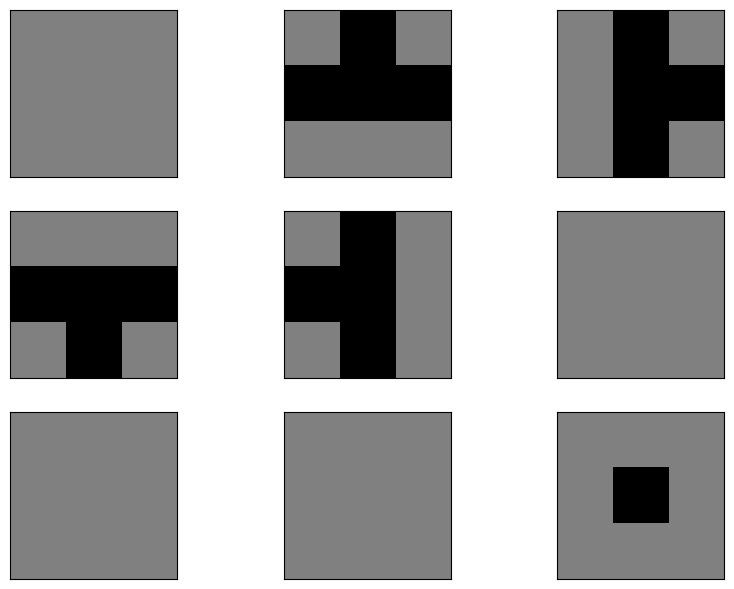

In [6]:
tileset = [
    [[128, 128, 128], [128, 128, 128], [128, 128, 128]],
    [[128, 0, 128], [0, 0, 0], [128, 128, 128]],
    [[128, 0, 128], [128, 0, 0], [128, 0, 128]],
    [[128, 128, 128], [0, 0, 0], [128, 0, 128]],
    [[128, 0, 128], [0, 0, 128], [128, 0, 128]],
    [[128, 128, 128], [128, 128, 128], [128, 128, 128]],
    [[128, 128, 128], [128, 128, 128], [128, 128, 128]],
    [[128, 128, 128], [128, 128, 128], [128, 128, 128]],
    [[128, 128, 128], [128, 0, 128], [128, 128, 128]],
]

tiles = {
    "BLANK": (0.2, 0),
    "UP": (0.2, 1),
    "RIGHT": (0.2, 2),
    "DOWN": (0.2, 3),
    "LEFT": (0.2, 4),
}

policies = {
    "BLANK": [
        ["BLANK", "UP"],
        ["BLANK", "RIGHT"],
        ["BLANK", "DOWN"],
        ["BLANK", "LEFT"],
    ],
    "UP": [
        ["RIGHT", "DOWN", "LEFT"],
        ["UP", "DOWN", "LEFT"],
        ["BLANK", "DOWN"],
        ["UP", "RIGHT", "DOWN"],
    ],
    "RIGHT": [
        ["RIGHT", "DOWN", "LEFT"],
        ["UP", "DOWN", "LEFT"],
        ["UP", "RIGHT", "LEFT"],
        ["BLANK", "LEFT"],
    ],
    "DOWN": [
        ["BLANK", "UP"],
        ["UP", "DOWN", "LEFT"],
        ["UP", "RIGHT", "LEFT"],
        ["UP", "RIGHT", "DOWN"],
    ],
    "LEFT": [
        ["RIGHT", "DOWN", "LEFT"],
        ["BLANK", "RIGHT"],
        ["UP", "RIGHT", "LEFT"],
        ["UP", "RIGHT", "DOWN"],
    ],
}
policies = unpack_policies(policies)

plt.figure(figsize=(10, 10))
for m in range(len(tileset)):
    axs = plt.subplot(4, math.ceil(len(tileset) / 3), m + 1)
    axs.imshow(tileset[m], cmap="gray", vmin=0, vmax=255)
    axs.set_xticks([])
    axs.set_yticks([])
plt.show()

Epoch:   0%|          | 0/64 [00:00<?, ?it/s]

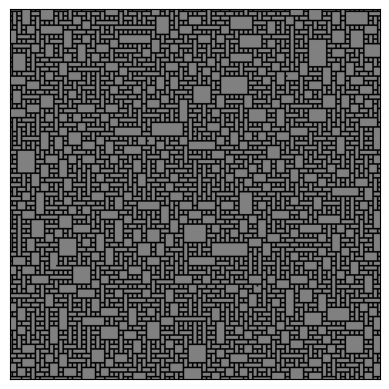

In [7]:
random.seed(0)

mymap = wave_collapse_function(tiles, policies, 80, 8)

if mymap is not None:
    fig, ax = plt.subplots()
    ax.imshow(grid_to_pixels(mymap, tileset, tiles, 8), cmap="gray", vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()